<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/08_ARCH_Tesla_Volatility_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARCH/GARCH-based Volatility Forecasting for Tesla (TSLA)

This notebook demonstrates **ARCH(1)** and **GARCH(1,1)** volatility forecasting for TSLA using R packages:
- Data: `quantmod` (Yahoo Finance)
- Models & forecasts: `rugarch`
- Diagnostics: `FinTS::ArchTest`

We evaluate four backtesting/operational modes (for **volatility**, not price):
1. **Full-sample (final fit)** – fit on all data and forecast future \(h\) days (not for evaluation).
2. **Fixed-origin (holdout)** – fit once on the first 80%, forecast the remaining horizon dynamically.
3. **Rolling-origin + Expanding window** – re-fit with an expanding window and produce **1-step** forecasts.
4. **Rolling-origin + Rolling window** – re-fit with a **fixed-length** moving window and produce **1-step** forecasts.

Metrics compare **variance forecasts** (\(\sigma_t^2\)) to **realized squared returns** (\(r_t^2\)):
- MSE: mean((\(r_t^2 - \sigma_t^2\))^2)
- QLIKE: mean( (\(r_t^2/\sigma_t^2\)) - log(\(r_t^2/\sigma_t^2\)) - 1 ), standard for volatility evaluation


In [1]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)
suppressWarnings({
  pkgs <- c("quantmod","rugarch","FinTS","PerformanceAnalytics","ggplot2","dplyr","tibble","xts","zoo")
  for (p in pkgs) {
    if (!requireNamespace(p, quietly = TRUE)) install.packages(p, repos = "https://cloud.r-project.org")
    library(p, character.only = TRUE)
  }
})


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘truncnorm’, ‘future.apply’, ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘mvtnorm’, ‘pracma’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘Rsolnp’, ‘ks’, ‘numDeriv’, ‘spd’, ‘chron’, ‘SkewHyperbolic’, ‘fracdiff’, ‘nloptr’, ‘RcppArmadillo’


Loading required package: parallel

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/

## 1) Load TSLA and Make Log Returns (%)

In [2]:
symbol <- "TSLA"
start  <- "2020-01-01"
end    <- "2024-01-01"

suppressWarnings(suppressMessages(
  getSymbols(symbol, src = "yahoo", from = start, to = end, auto.assign = TRUE)
))
px_all <- get(symbol)
price  <- if ("Adjusted" %in% colnames(px_all)) Ad(px_all) else Cl(px_all)
ret    <- na.omit(100 * diff(log(price)))
colnames(ret) <- "ret"
cat(sprintf("%s: %d obs | %s ~ %s\n", symbol, NROW(ret), index(ret)[1], index(ret)[NROW(ret)]))

# Train/test split (80/20)
split <- floor(NROW(ret) * 0.8)
ret_train <- ret[1:split]
ret_test  <- ret[(split+1):NROW(ret)]
cat(sprintf("train=%d, test=%d\n", NROW(ret_train), NROW(ret_test)))


[1] "TSLA"

TSLA: 1005 obs | 2020-01-03 ~ 2023-12-29
train=804, test=201


## 2) Quick Look & Diagnostics (Volatility Clustering)

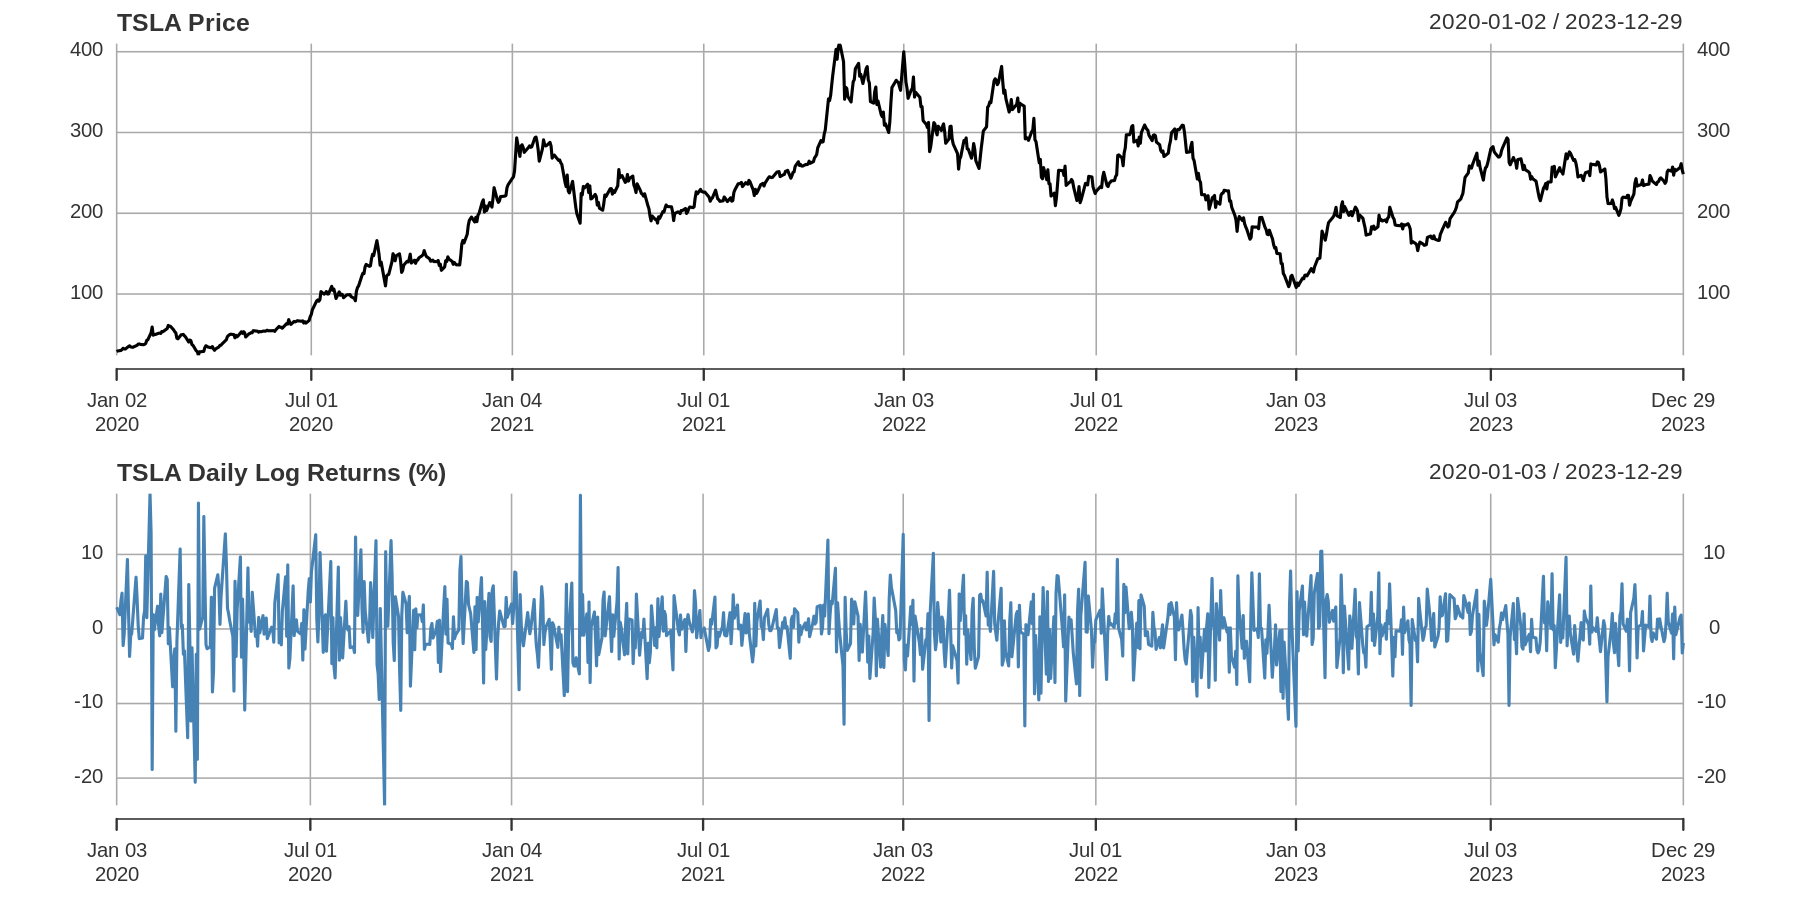


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  as.numeric(ret)
Chi-squared = 78.179, df = 12, p-value = 9.17e-12



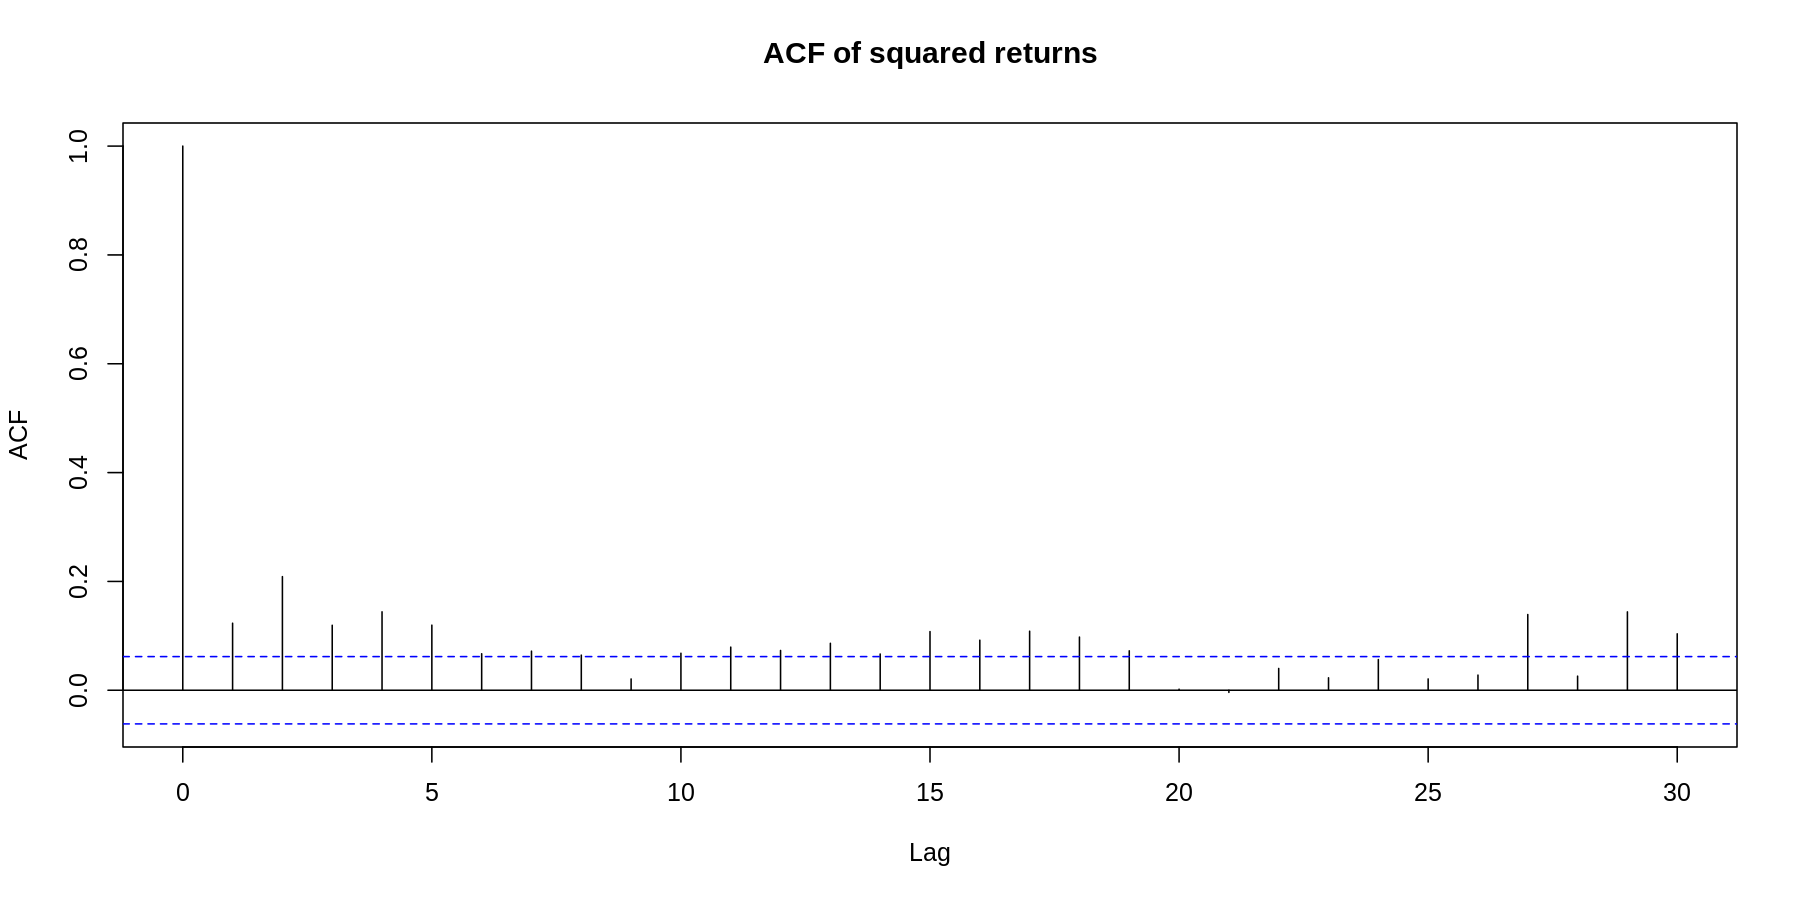

In [3]:
autoplot.zoo <- function(x, ...) { plot(zoo::zoo(x, order.by = index(x)), ...) }
par(mfrow = c(2,1))
plot(price, main = "TSLA Price", col = "black")
plot(ret,   main = "TSLA Daily Log Returns (%)", col = "steelblue")
par(mfrow = c(1,1))

# ACF of squared returns
acf(as.numeric(ret^2), lag.max = 30, main = "ACF of squared returns")

# ARCH LM Test
print(FinTS::ArchTest(as.numeric(ret), lags = 12))


## 3) Specify ARCH(1) and GARCH(1,1) Models

In [4]:
# ARCH(1): variance.model garchOrder = c(1,0)
spec_arch1 <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1,0)),
  mean.model     = list(armaOrder = c(0,0), include.mean = TRUE),
  distribution.model = "norm"
)

# GARCH(1,1): benchmark
spec_garch11 <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
  mean.model     = list(armaOrder = c(0,0), include.mean = TRUE),
  distribution.model = "norm"
)


## 4) A) Full-sample (final fit) — fit on all data → forecast next *h* days


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.214410    0.117567   1.8237 0.068194
omega   0.392030    0.164844   2.3782 0.017398
alpha1  0.075769    0.016399   4.6202 0.000004
beta1   0.903553    0.020788  43.4661 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.214410    0.128910   1.6632 0.096263
omega   0.392030    0.321207   1.2205 0.222279
alpha1  0.075769    0.022842   3.3171 0.000910
beta1   0.903553    0.032826  27.5255 0.000000

LogLikelihood : -2821.954 

Information Criteria
------------------------------------
                   
Akaike       5.6238
Bayes        5.6433
Shibata      5.6238
Hannan-Quinn 5.6312

Weighted

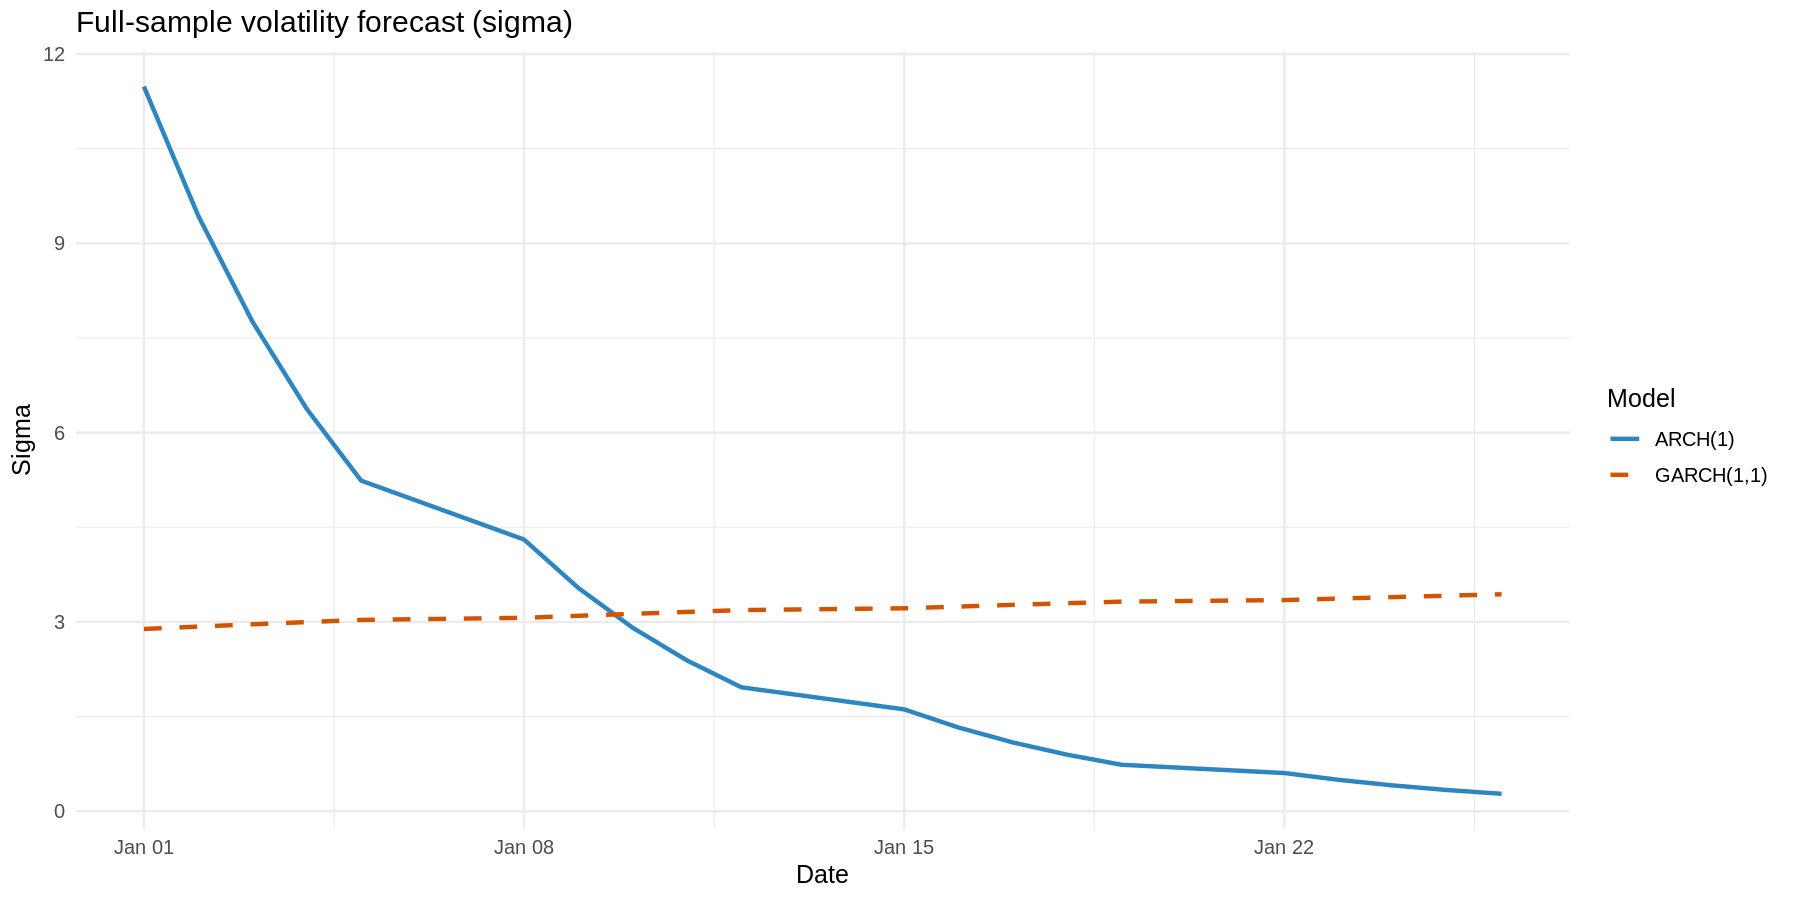

In [5]:
h <- 20  # horizon
fit_arch1_full   <- ugarchfit(spec_arch1,   data = ret, solver = "hybrid")
fit_garch11_full <- ugarchfit(spec_garch11, data = ret, solver = "hybrid")
show(fit_garch11_full)

fc_arch1_full   <- ugarchforecast(fit_arch1_full,   n.ahead = h)
fc_garch11_full <- ugarchforecast(fit_garch11_full, n.ahead = h)
sig_arch1_future   <- as.numeric(sigma(fc_arch1_full))
sig_garch11_future <- as.numeric(sigma(fc_garch11_full))

last_date <- as.Date(index(price)[NROW(price)])
future_dates <- seq(from = last_date + 1, by = "day", length.out = h*2)
future_dates <- future_dates[weekdays(future_dates) %in% c("Monday","Tuesday","Wednesday","Thursday","Friday")][1:h]

df_future <- tibble::tibble(Date = future_dates, ARCH1 = sig_arch1_future, GARCH11 = sig_garch11_future)
ggplot(df_future, aes(Date)) +
  geom_line(aes(y = ARCH1,  color = "ARCH(1)"), linewidth = 1) +
  geom_line(aes(y = GARCH11, color = "GARCH(1,1)"), linewidth = 1, linetype = "dashed") +
  scale_color_manual(values = c("ARCH(1)" = "#2E86C1", "GARCH(1,1)" = "#D35400")) +
  labs(title = "Full-sample volatility forecast (sigma)", x = "Date", y = "Sigma", color = "Model") +
  theme_minimal(base_size = 12)


## 4) B) Fixed-origin (holdout) — fit on first 80%, forecast entire test horizon (dynamic)

[Fixed-origin] ARCH(1)  MSE=115920.815207 | QLIKE=4.020137
[Fixed-origin] GARCH(1,1) MSE=454.920772 | QLIKE=1.687069


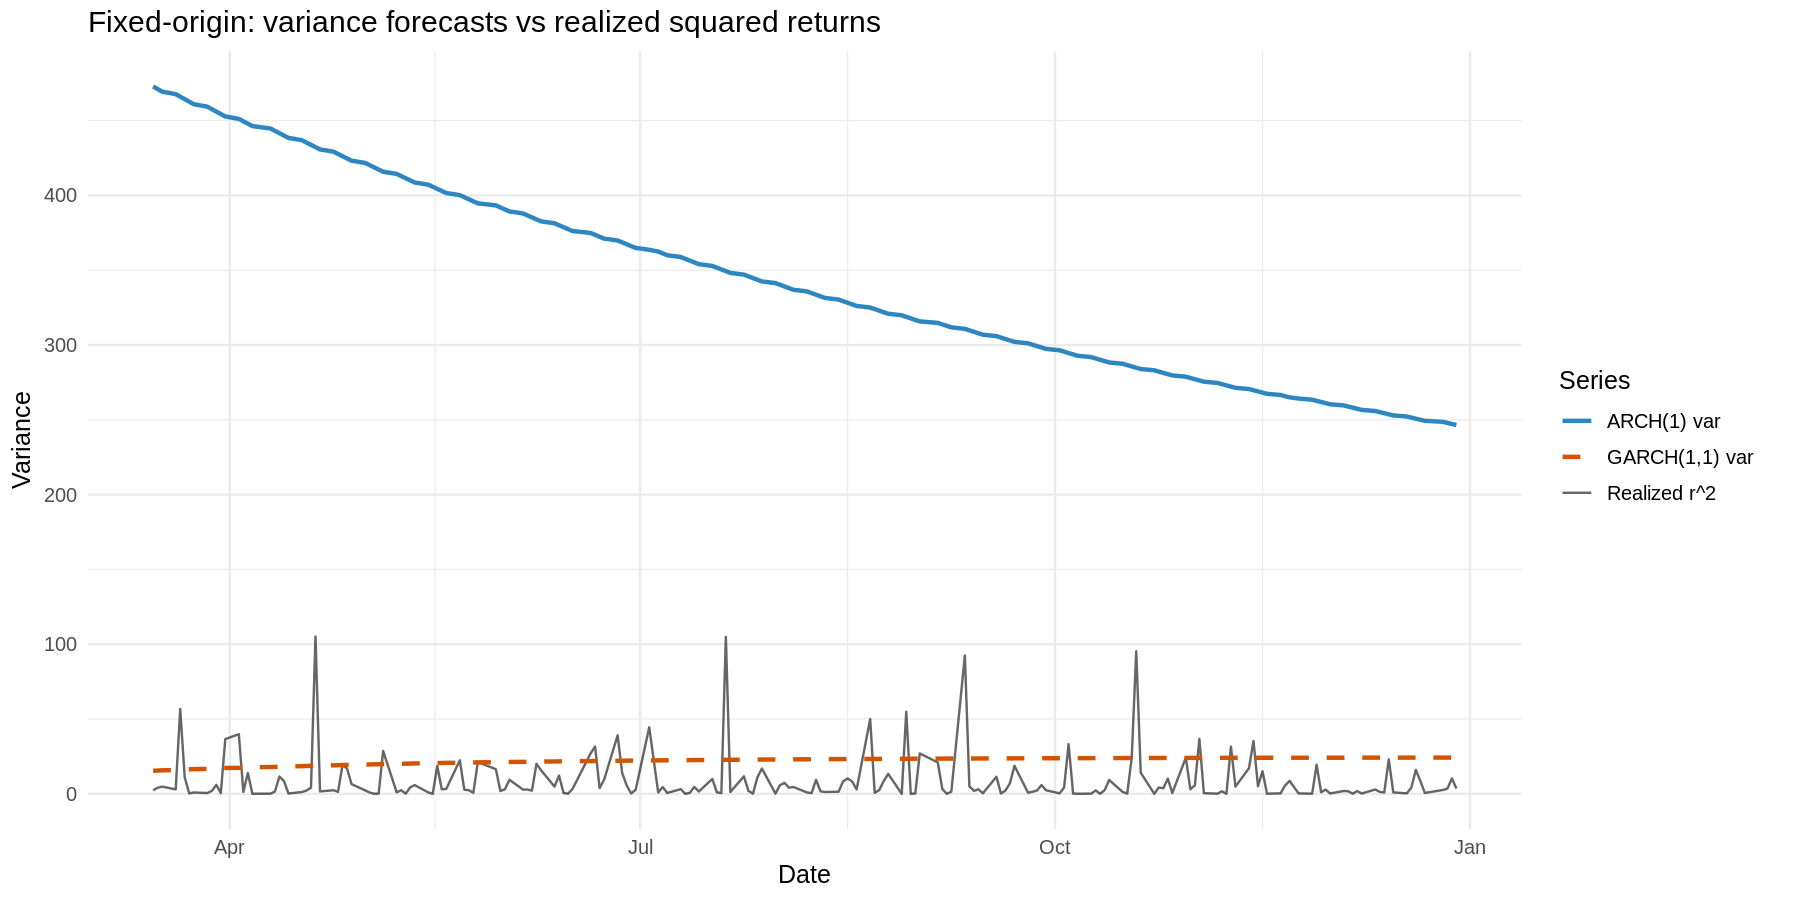

In [6]:
fit_arch1_fix   <- ugarchfit(spec_arch1,   data = ret_train, solver = "hybrid")
fit_garch11_fix <- ugarchfit(spec_garch11, data = ret_train, solver = "hybrid")

# Dynamic volatility forecasts for the test horizon
fc_arch1_fix   <- ugarchforecast(fit_arch1_fix,   n.ahead = NROW(ret_test))
fc_garch11_fix <- ugarchforecast(fit_garch11_fix, n.ahead = NROW(ret_test))
sig_arch1_fix   <- as.numeric(sigma(fc_arch1_fix))
sig_garch11_fix <- as.numeric(sigma(fc_garch11_fix))

# Evaluation: compare r_t^2 vs sigma_t^2
r2_test <- as.numeric(ret_test)^2
mse  <- function(a,b) mean((a-b)^2)
qlike <- function(r2, sig2) mean(r2/sig2 - log(r2/sig2) - 1)

mse_arch_fix   <- mse(r2_test, sig_arch1_fix^2)
mse_garch_fix  <- mse(r2_test, sig_garch11_fix^2)
ql_arch_fix    <- qlike(pmax(r2_test, 1e-10), pmax(sig_arch1_fix^2, 1e-10))
ql_garch_fix   <- qlike(pmax(r2_test, 1e-10), pmax(sig_garch11_fix^2, 1e-10))

cat(sprintf("[Fixed-origin] ARCH(1)  MSE=%.6f | QLIKE=%.6f\n", mse_arch_fix,  ql_arch_fix))
cat(sprintf("[Fixed-origin] GARCH(1,1) MSE=%.6f | QLIKE=%.6f\n", mse_garch_fix, ql_garch_fix))

df_fix <- tibble::tibble(Date = index(ret_test), r2 = r2_test, ARCH1 = sig_arch1_fix^2, GARCH11 = sig_garch11_fix^2)
ggplot(df_fix, aes(Date)) +
  geom_line(aes(y = r2,      color = "Realized r^2"), alpha = 0.6) +
  geom_line(aes(y = ARCH1,   color = "ARCH(1) var"), linewidth = 1) +
  geom_line(aes(y = GARCH11, color = "GARCH(1,1) var"), linewidth = 1, linetype = "dashed") +
  scale_color_manual(values = c("Realized r^2" = "black", "ARCH(1) var" = "#2E86C1", "GARCH(1,1) var" = "#D35400")) +
  labs(title = "Fixed-origin: variance forecasts vs realized squared returns",
       x = "Date", y = "Variance", color = "Series") +
  theme_minimal(base_size = 12)


## 4) C) Rolling-origin + **Expanding** window (1-step ahead via `ugarchroll`)

In [7]:
# 1-step ahead recursive forecasts, refit every K points with an expanding window
K <- 20  # refit frequency (you can increase if slow)
roll_arch_exp   <- ugarchroll(spec_arch1,   data = ret, n.ahead = 1, forecast.length = NROW(ret_test),
                              refit.every = K, refit.window = "expanding", solver = "hybrid",
                              calculate.VaR = FALSE, keep.coef = TRUE)
roll_garch_exp  <- ugarchroll(spec_garch11, data = ret, n.ahead = 1, forecast.length = NROW(ret_test),
                              refit.every = K, refit.window = "expanding", solver = "hybrid",
                              calculate.VaR = FALSE, keep.coef = TRUE)

sig_arch_exp   <- as.numeric(roll_arch_exp@forecast$sigmaFor)
sig_garch_exp  <- as.numeric(roll_garch_exp@forecast$sigmaFor)
r2_test        <- as.numeric(ret_test)^2
mse_arch_exp   <- mean((r2_test - sig_arch_exp^2)^2)
mse_garch_exp  <- mean((r2_test - sig_garch_exp^2)^2)
ql_arch_exp    <- mean(pmax(r2_test,1e-10)/pmax(sig_arch_exp^2,1e-10) - log(pmax(r2_test,1e-10)/pmax(sig_arch_exp^2,1e-10)) - 1)
ql_garch_exp   <- mean(pmax(r2_test,1e-10)/pmax(sig_garch_exp^2,1e-10) - log(pmax(r2_test,1e-10)/pmax(sig_garch_exp^2,1e-10)) - 1)

cat(sprintf("[Expanding] ARCH(1)  MSE=%.6f | QLIKE=%.6f\n", mse_arch_exp,  ql_arch_exp))
cat(sprintf("[Expanding] GARCH(1,1) MSE=%.6f | QLIKE=%.6f\n", mse_garch_exp, ql_garch_exp))


[Expanding] ARCH(1)  MSE=NaN | QLIKE=NaN
[Expanding] GARCH(1,1) MSE=NaN | QLIKE=NaN


## 4) D) Rolling-origin + **Rolling** window (1-step ahead via `ugarchroll`)

In [8]:
W <- 250  # window size (about 1 trading year)
roll_arch_mov   <- ugarchroll(spec_arch1,   data = ret, n.ahead = 1, forecast.length = NROW(ret_test),
                              refit.every = K, refit.window = "moving", window.size = W, solver = "hybrid",
                              calculate.VaR = FALSE, keep.coef = TRUE)
roll_garch_mov  <- ugarchroll(spec_garch11, data = ret, n.ahead = 1, forecast.length = NROW(ret_test),
                              refit.every = K, refit.window = "moving", window.size = W, solver = "hybrid",
                              calculate.VaR = FALSE, keep.coef = TRUE)

sig_arch_mov   <- as.numeric(roll_arch_mov@forecast$sigmaFor)
sig_garch_mov  <- as.numeric(roll_garch_mov@forecast$sigmaFor)

mse_arch_mov   <- mean((r2_test - sig_arch_mov^2)^2)
mse_garch_mov  <- mean((r2_test - sig_garch_mov^2)^2)
ql_arch_mov    <- mean(pmax(r2_test,1e-10)/pmax(sig_arch_mov^2,1e-10) - log(pmax(r2_test,1e-10)/pmax(sig_arch_mov^2,1e-10)) - 1)
ql_garch_mov   <- mean(pmax(r2_test,1e-10)/pmax(sig_garch_mov^2,1e-10) - log(pmax(r2_test,1e-10)/pmax(sig_garch_mov^2,1e-10)) - 1)

cat(sprintf("[Rolling]   ARCH(1)  MSE=%.6f | QLIKE=%.6f\n", mse_arch_mov,  ql_arch_mov))
cat(sprintf("[Rolling]   GARCH(1,1) MSE=%.6f | QLIKE=%.6f\n", mse_garch_mov, ql_garch_mov))


[Rolling]   ARCH(1)  MSE=NaN | QLIKE=NaN
[Rolling]   GARCH(1,1) MSE=NaN | QLIKE=NaN


## 5) Summary Table

In [9]:
summary_tbl <- tibble::tibble(
  Method  = c("Fixed-origin ARCH(1)", "Fixed-origin GARCH(1,1)",
              "Expanding ARCH(1)",   "Expanding GARCH(1,1)",
              "Rolling ARCH(1)",     "Rolling GARCH(1,1)"),
  MSE     = c(mse_arch_fix,  mse_garch_fix,
              mse_arch_exp,  mse_garch_exp,
              mse_arch_mov,  mse_garch_mov),
  QLIKE   = c(ql_arch_fix,   ql_garch_fix,
              ql_arch_exp,   ql_garch_exp,
              ql_arch_mov,   ql_garch_mov)
) %>% arrange(MSE)
print(summary_tbl)


# A tibble: 6 × 3
  Method                      MSE  QLIKE
  <chr>                     <dbl>  <dbl>
1 Fixed-origin GARCH(1,1)    455.   1.69
2 Fixed-origin ARCH(1)    115921.   4.02
3 Expanding ARCH(1)          NaN  NaN   
4 Expanding GARCH(1,1)       NaN  NaN   
5 Rolling ARCH(1)            NaN  NaN   
6 Rolling GARCH(1,1)         NaN  NaN   
